# Virtual species

In this vignette, we provide a demonstration of how the different **SpeciesDistributionToolkit** functions can be chained together to rapidly create a virtual species, generate its range map, and sample points from it according to the predicted suitability.

In [1]:
using SpeciesDistributionToolkit
const SDT = SpeciesDistributionToolkit
using CairoMakie
using Statistics
CairoMakie.activate!(px_per_unit=6.0)

We start by defining the extent in which we want to create the virtual species. For the purpose of this example, we will use the country of Austria, a polygon of which is available in the GADM database. Note that the `boundingbox` function returns the coordinates *in WGS84*. We have used these commands already in the first case study.

In [2]:
place = getpolygon(PolygonData(OpenStreetMap, Places), place="Paraguay")
extent = SDT.boundingbox(place)

(left = -62.64066696166992, right = -54.257999420166016, bottom = -27.606393814086914, top = -19.287647247314453)

We then download some environmental data. In this example, we use the BioClim variables as distributed by CHELSA. In order to simplify the code, we will only use BIO1 (mean annual temperature) and BIO12 (total annual precipitation). Note that we collect these layers in a vector typed as `SDMLayer{Float32}`, in order to ensure that future operations already recevie floating point values.

In [5]:
provider = RasterData(CHELSA2, BioClim)
L = SDMLayer{Float32}[SDMLayer(provider; layer=l, extent...) for l in ["BIO1", "BIO12"]]

2-element Vector{SDMLayer{Float32}}:
 🗺️  A 999 × 1007 layer (1005993 Float32 cells)
 🗺️  A 999 × 1007 layer (1005993 Float32 cells)

We now mask the layers using the polygons we downloaded initially, and rescale all of them between 0 and 1:

In [6]:
rescale!.(mask!(L, place))

2-element Vector{SDMLayer{Float32}}:
 🗺️  A 999 × 1007 layer (508483 Float32 cells)
 🗺️  A 999 × 1007 layer (508483 Float32 cells)

In the next steps, we will generate some virtual species. These are defined by an environmental response to each layer, linking the value of the layer at a point to the suitability score. For the sake of expediency, we only use logistic responses, and generate one function for each layer (drawing $\alpha$ from a normal distribution, and $\beta$ uniformly).

In [7]:
logistic(x, α, β) = 1 / (1 + exp((x - β) / α))
logistic(α, β) = (x) -> logistic(x, α, β)

logistic (generic function with 2 methods)

We will next write a function that will sample a value in each layer to serve as the center of the logistic response, draw a shape parameter at random, and then return the suitability of the environment for a virtual species under the assumption of a set prevalence:

In [8]:
function virtualspecies(L::Vector{<:SDMLayer}; prevalence::Float64=0.25)
    prevalence = clamp(prevalence, eps(), 1.0)
    # The center of the response is a random value in the layer
    invalid = true
    while invalid
        centers = [rand(values(l)) for l in L]
        shapes = randn(length(L))
        # The shape is a random Normal
        predictors = [logistic(centers[i], shapes[i]) for i in eachindex(L)]
        # We can generate a prediction for each layer
        predictions = [predictors[i].(L[i]) for i in eachindex(L)]
        # We rescale the response of all layers so that it is is 0-1
        rescale!.(predictions)
        # We predict the response by multiplying the values
        global prediction = prod(predictions)
        # We normalize the prediction so it is in 0-1
        rescale!(prediction)
        # Check that there are no NaN values
        invalid = any(isnan, prediction)
    end
    # We identify the cutoff based on the prevalence
    cutoff = quantile(prediction, 1 - prevalence)
    # Then we return the prediction, the cutoff, and the range
    return prediction, cutoff, prediction .>= cutoff
end

virtualspecies (generic function with 1 method)

We can not apply this new function to create a simulated species distribution:

In [9]:
vsp, τ, vrng = virtualspecies(L; prevalence=0.33)

(🗺️  A 999 × 1007 layer (508483 Float64 cells), 0.36975846064128104, 🗺️  A 999 × 1007 layer (508483 Bool cells))

We can plot the output of this function to inspect what the generated range looks like:

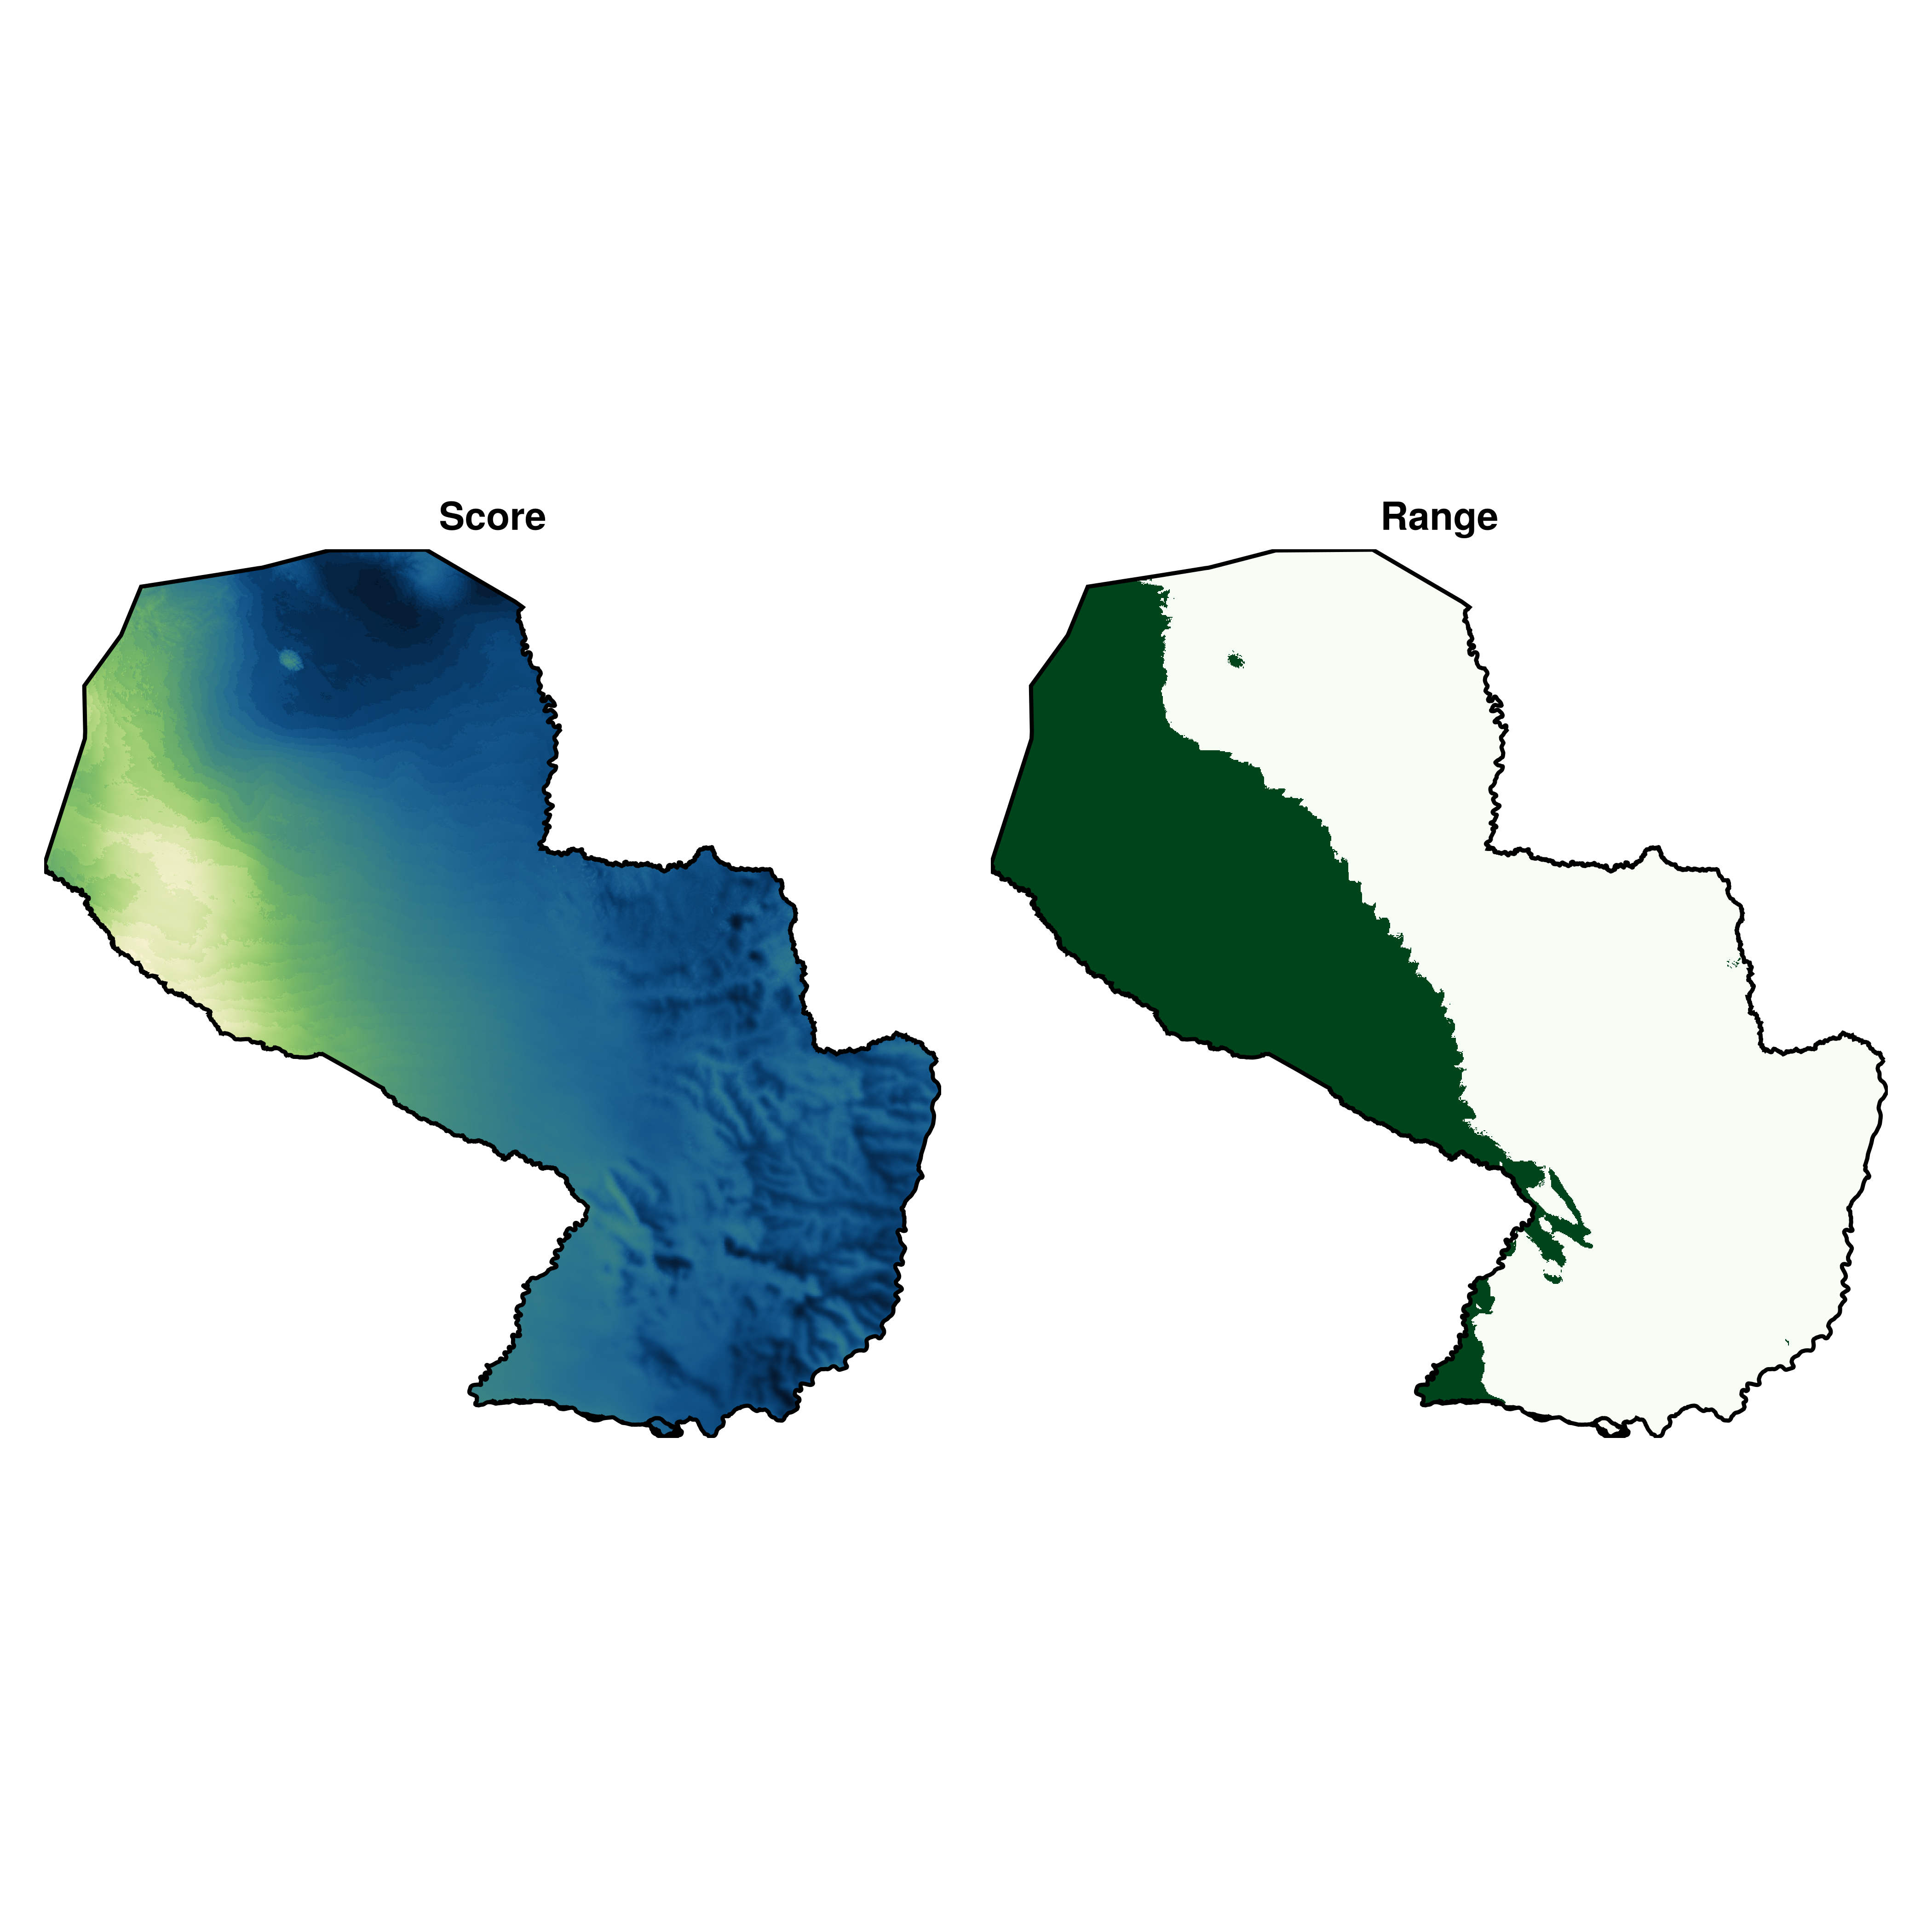

In [10]:
f = Figure(size=(700, 700))
ax1 = Axis(f[1, 1]; aspect=DataAspect(), title="Score")
ax2 = Axis(f[1, 2]; aspect=DataAspect(), title="Range")
heatmap!(ax1, vsp, colormap=:navia)
heatmap!(ax2, vrng, colormap=:Greens)
for ax in [ax1, ax2]
    tightlimits!(ax)
    hidedecorations!(ax)
    hidespines!(ax)
    lines!(ax, place, color=:black)
end
f

Random observations for the virtual species are generated by setting the probability of inclusion to 0 for all values above the cutoff, and then sampling proportionally to the suitability for all remaining points. Note that the method is called `backgroundpoints`, as it is normally used for pseudo-absences. The second argument of this method is the number of points to generate.

In [11]:
presencelayer = backgroundpoints(mask(vsp, nodata(vrng, false)), 100)

🗺️  A 999 × 1007 layer with 167800 Bool cells
   Projection: +proj=longlat +datum=WGS84 +no_defs

We can finally plot the result:

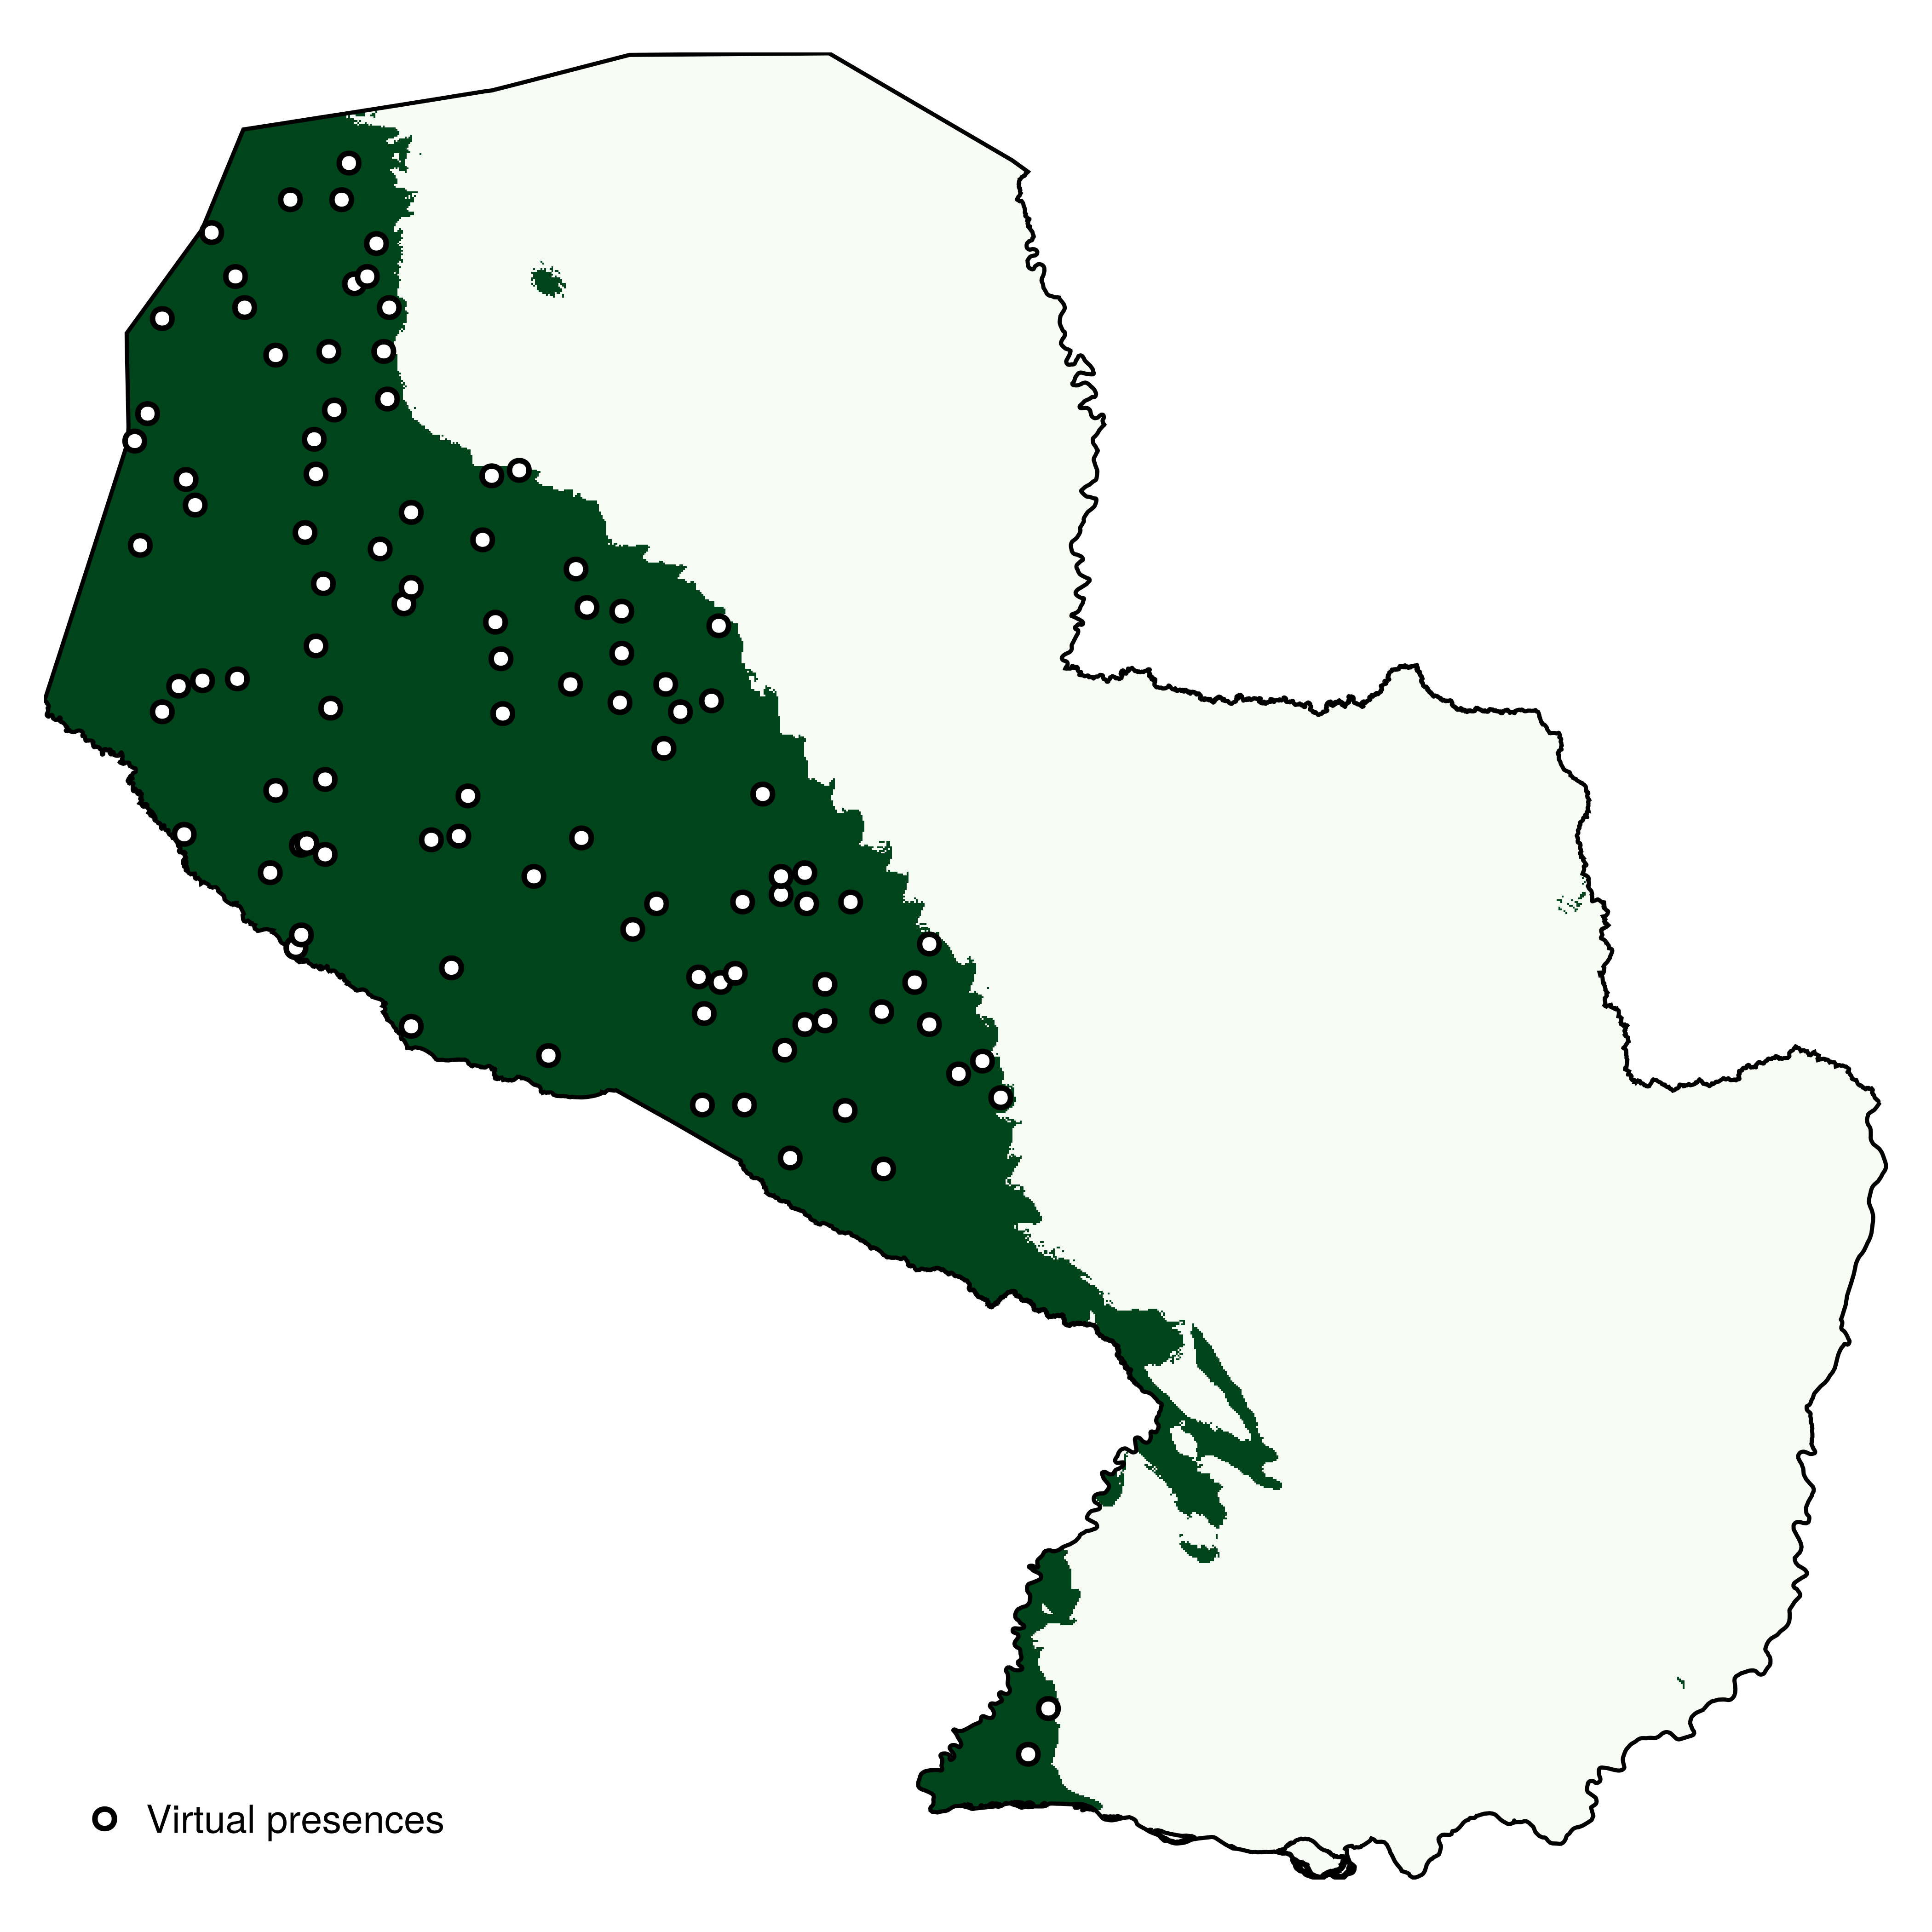

In [12]:
f = Figure(size=(700, 700))
ax = Axis(f[1, 1], aspect=DataAspect())
heatmap!(ax, vrng, colormap=:Greens)
lines!(ax, place, color=:black)
scatter!(ax, presencelayer, color=:white, strokecolor=:black, strokewidth=2, markersize=10, label="Virtual presences")
tightlimits!(ax)
hidespines!(ax)
hidedecorations!(ax)
axislegend(ax, position=:lb, framevisible=false)
f

These data could, for example, be used to benchmark species distribution models. For the analysis presented in the manuscript, we are interested in applying the simulation of virtual species to a large number, in order to say something about potential patterns of biodiversity. For this reason, we will now simulate 100 species, with prevalences drawn uniformly in the unit interval.

In [13]:
ranges = [virtualspecies(L; prevalence=rand())[3] for _ in 1:100]

100-element Vector{SDMLayer{Bool}}:
 🗺️  A 999 × 1007 layer (508483 Bool cells)
 🗺️  A 999 × 1007 layer (508483 Bool cells)
 🗺️  A 999 × 1007 layer (508483 Bool cells)
 🗺️  A 999 × 1007 layer (508483 Bool cells)
 🗺️  A 999 × 1007 layer (508483 Bool cells)
 🗺️  A 999 × 1007 layer (508483 Bool cells)
 🗺️  A 999 × 1007 layer (508483 Bool cells)
 🗺️  A 999 × 1007 layer (508483 Bool cells)
 🗺️  A 999 × 1007 layer (508483 Bool cells)
 🗺️  A 999 × 1007 layer (508483 Bool cells)
 ⋮
 🗺️  A 999 × 1007 layer (508483 Bool cells)
 🗺️  A 999 × 1007 layer (508483 Bool cells)
 🗺️  A 999 × 1007 layer (508483 Bool cells)
 🗺️  A 999 × 1007 layer (508483 Bool cells)
 🗺️  A 999 × 1007 layer (508483 Bool cells)
 🗺️  A 999 × 1007 layer (508483 Bool cells)
 🗺️  A 999 × 1007 layer (508483 Bool cells)
 🗺️  A 999 × 1007 layer (508483 Bool cells)
 🗺️  A 999 × 1007 layer (508483 Bool cells)

We can sum these layers to obtain a measurement of the simulated species richness:

In [14]:
richness = mosaic(sum, ranges)

🗺️  A 999 × 1007 layer with 508483 Int64 cells
   Projection: +proj=longlat +datum=WGS84 +no_defs

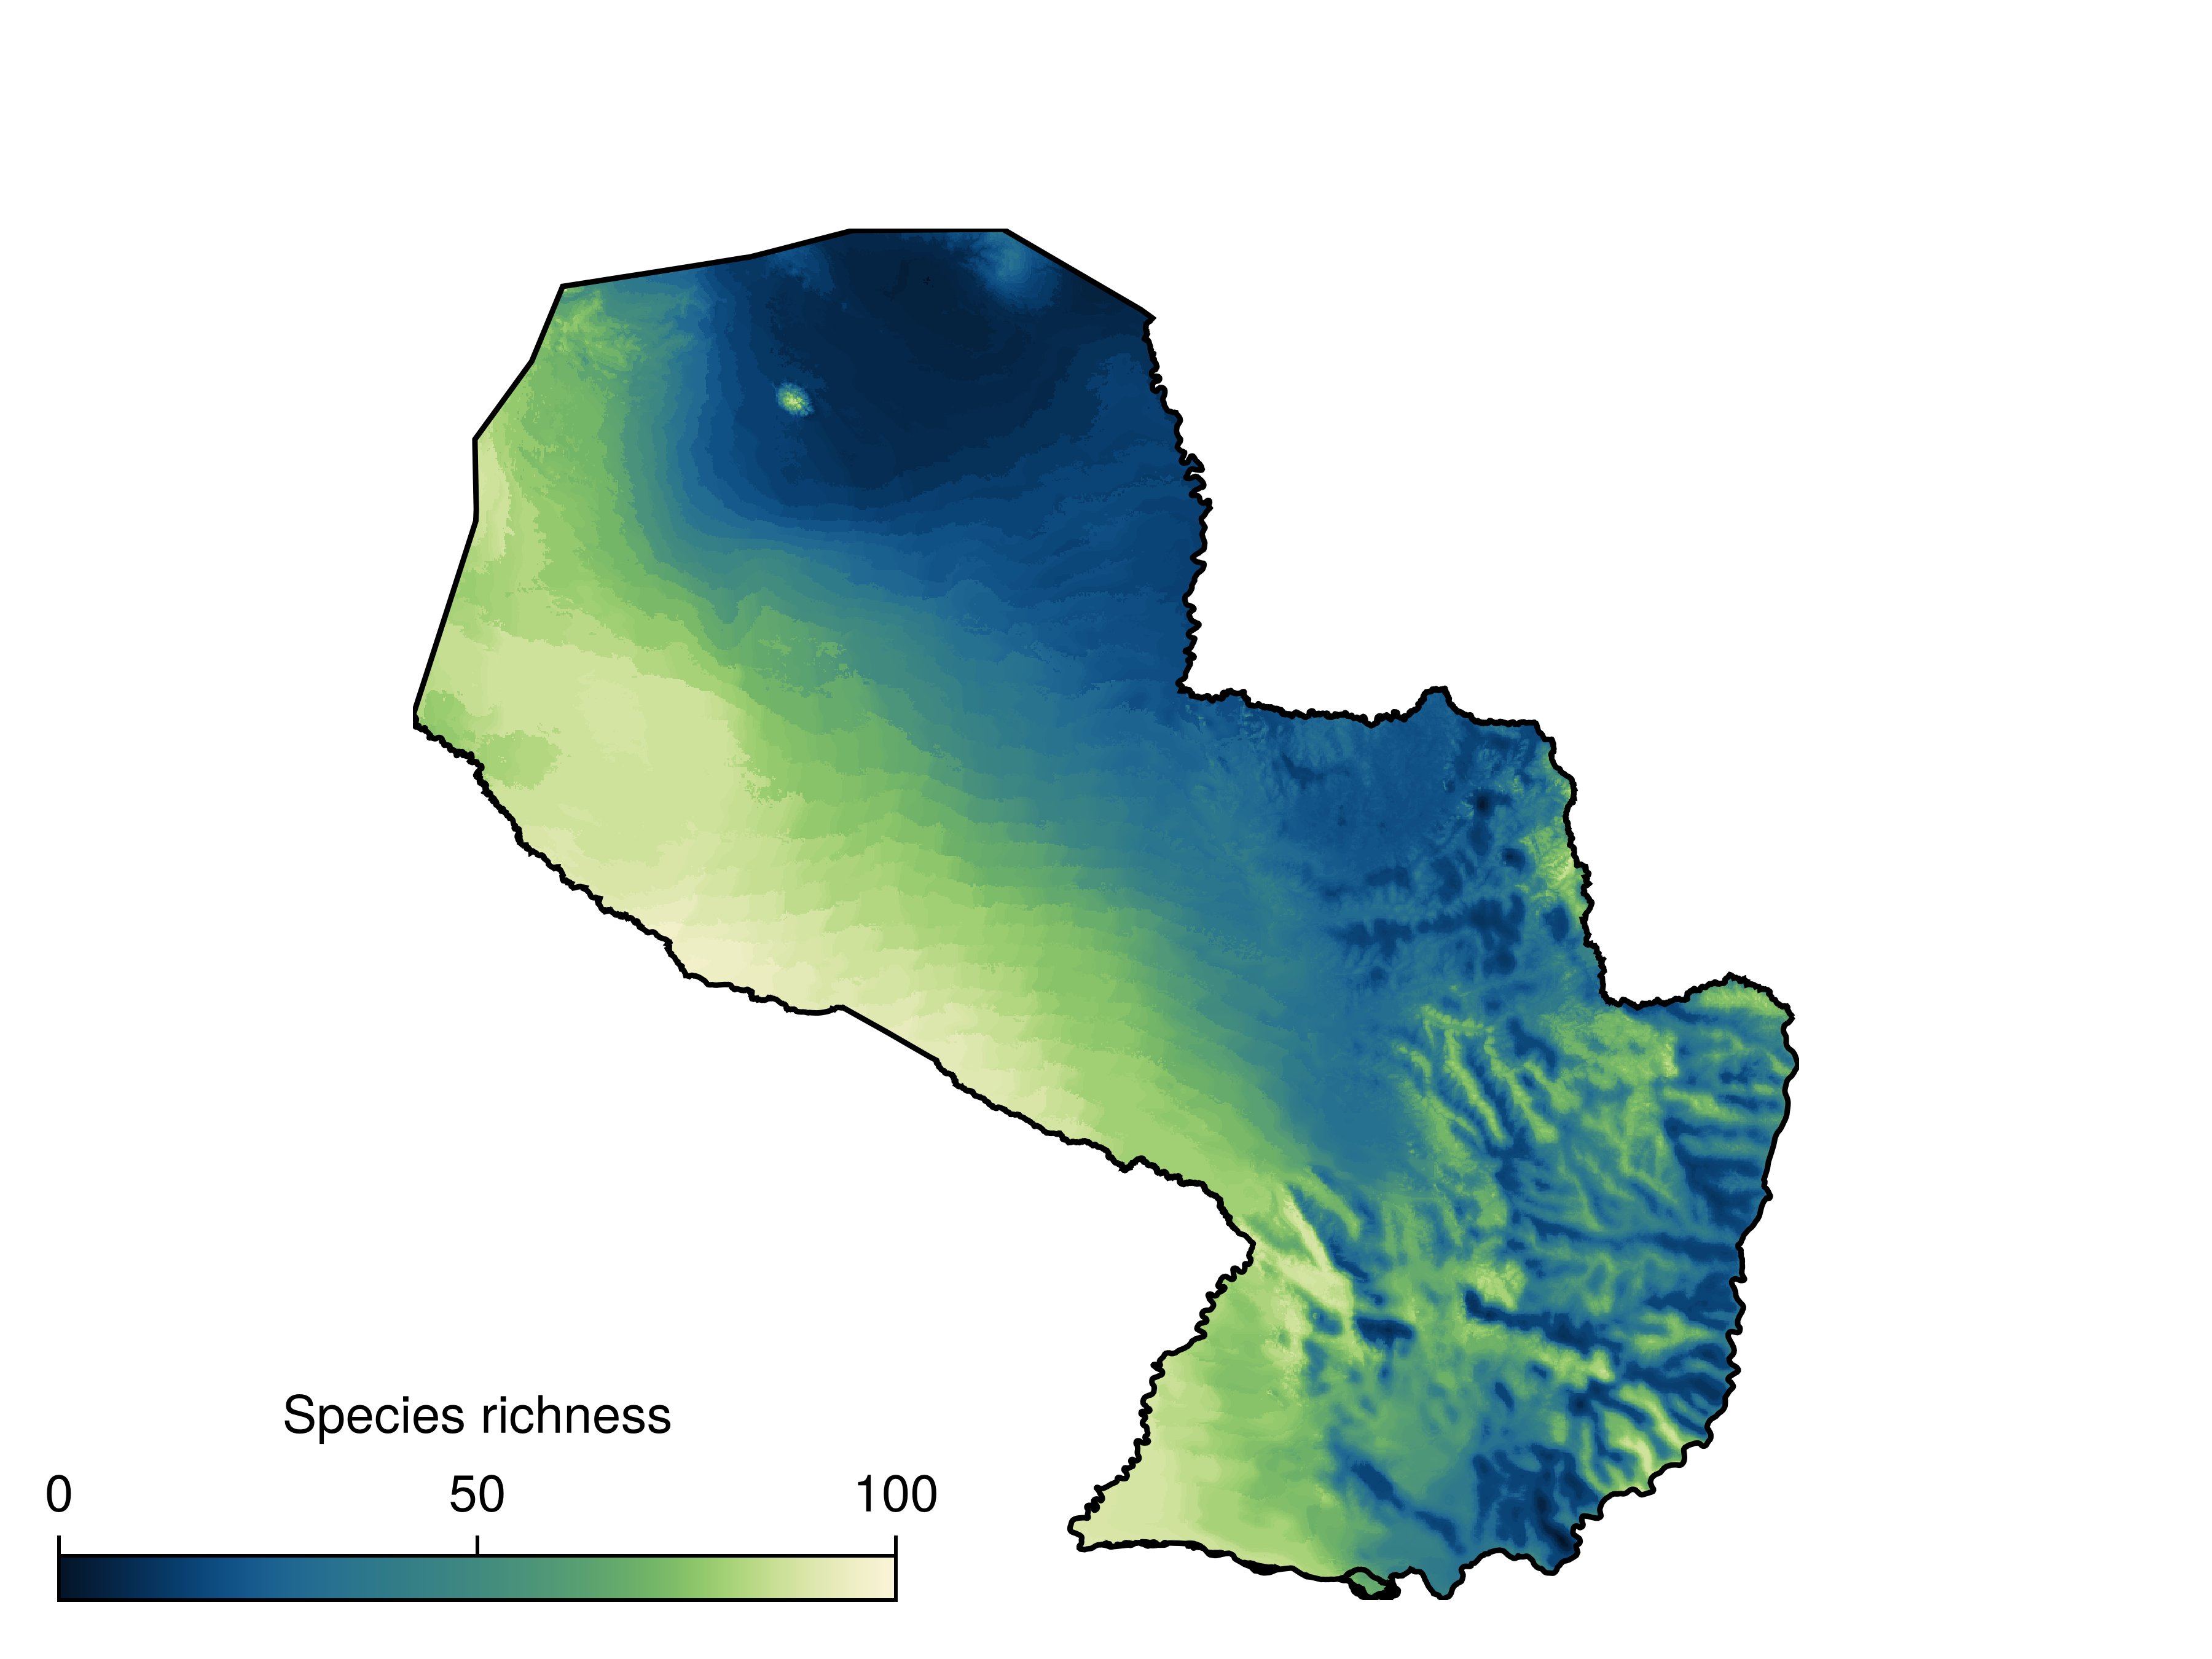

In [15]:
f = Figure()
ax = Axis(f[1, 1]; aspect=DataAspect())
hm = heatmap!(ax, richness, colorrange=(0, length(ranges)), colormap=:navia)
Colorbar(f[1, 1], hm, label="Species richness", alignmode=Inside(), width=Relative(0.4), valign=:bottom, halign=:left, tellheight=false, tellwidth=false, vertical=false)
hidedecorations!(ax)
lines!(ax, place, color=:black)
hidespines!(ax)
f

We can now transform these data into a partition of the contribution of each species and location to the total beta-diversity:

In [16]:
function LCBD(ranges::Vector{SDMLayer{Bool}}; transformation::Function=identity)
    Y = transformation(hcat(values.(ranges)...))
    S = (Y .- mean(Y; dims=1)) .^ 2.0
    SStotal = sum(S)
    BDtotal = SStotal / (size(Y, 1) - 1)
    SSj = sum(S; dims=1)
    SCBDj = SSj ./ SStotal
    SSi = sum(S; dims=2)
    LCBDi = SSi ./ SStotal
    # LCBD raster
    betadiv = similar(first(ranges), Float32)
    betadiv.grid[findall(betadiv.indices)] .= vec(LCBDi)
    return betadiv, vec(SCBDj), BDtotal
end

LCBD (generic function with 1 method)

For good measure, we will also add a function to perform the Hellinger transformation:

In [17]:
function hellinger(Y::AbstractMatrix{T}) where {T<:Number}
    yi = sum(Y; dims=2) .+ 1 # This is important to ensure that empty locations are included
    return sqrt.(Y ./ yi)
end

hellinger (generic function with 1 method)

We can now apply this function to our simulated ranges. The first output is a layer with the local contributions to beta diversity (LCBD), the second is a vector with the contribution of species, and the last element is the total beta diversity.

In [18]:
βl, βs, βt = LCBD(ranges; transformation=hellinger)

(🗺️  A 999 × 1007 layer (508483 Float32 cells), [0.01221462628082523, 0.00937476165938854, 0.0017235308528385444, 0.008075838208930883, 0.015842607729457555, 0.010454950503777144, 0.012838853795381047, 0.01671061553181355, 0.00212725853152195, 0.010375664750134099  …  0.006682088838570285, 0.011251826820949558, 0.007958384728152213, 0.009130878317777785, 0.011785767528457952, 0.008945800753449789, 0.011467814443590837, 0.010364171075740534, 0.0016462603772672629, 0.011373469934351349], 0.3568782585588923)

We can now plot the various elements (most of the code below is actually laying out the sub-panels for the plot):

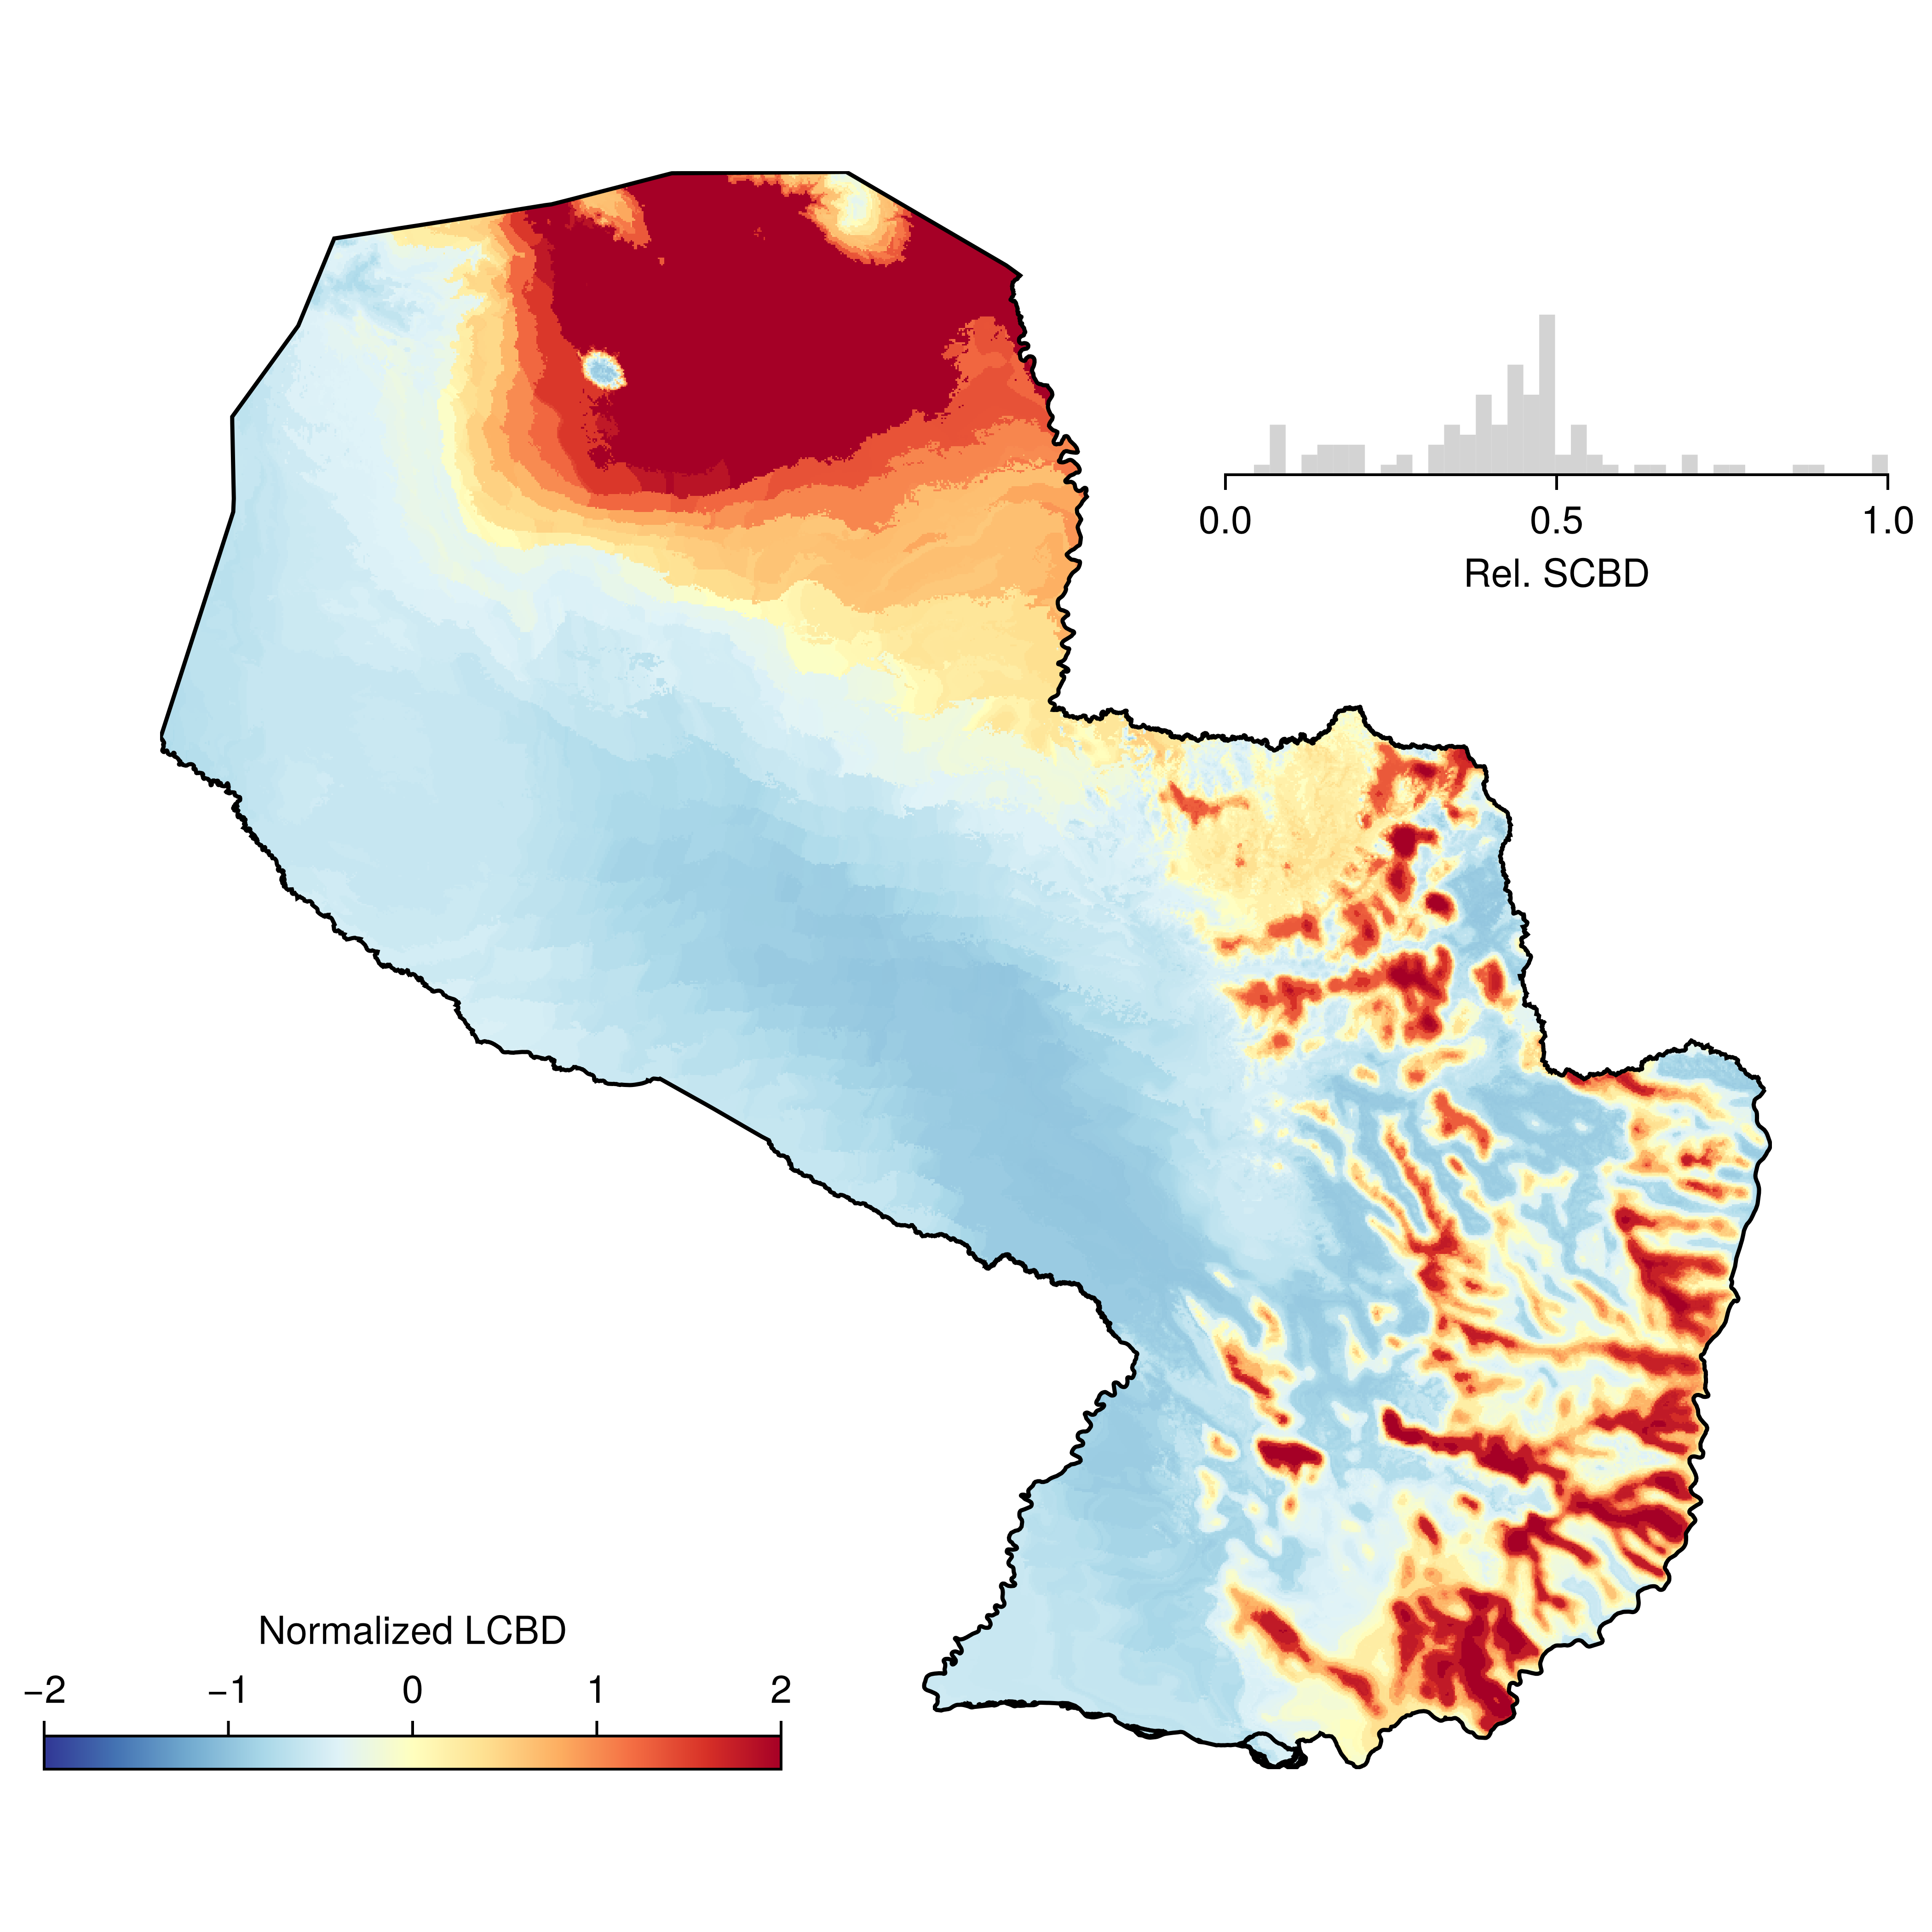

In [19]:
#| label: fig-virtual-species
#| fig-cap: Virtual distribution of normalized (mean of 0 and unit variance) locality contribution to beta-diversity [@Legendre2013], based on a pool of 100 virtual species. The inset histogram represents the standardized species contribution to beta-diversity. Red areas represent comparatively more unique areas in terms of simulated species composition. The code to produce this ﬁgure is available as Supp. Mat. 4.
f = Figure(size=(700, 700))
ax = Axis(f[1, 1], aspect=DataAspect())
hm = heatmap!(ax, (βl - mean(βl)) / std(βl), colormap=Reverse(:RdYlBu), colorrange=(-2, 2))
lines!(ax, place, color=:black)
Colorbar(f[1, 1], hm, label="Normalized LCBD", alignmode=Inside(), width=Relative(0.4), valign=:bottom, halign=:left, tellheight=false, tellwidth=false, vertical=false)
tightlimits!(ax)
hidespines!(ax)
hidedecorations!(ax)
ax_inset = Axis(f[1, 1],
    width=Relative(0.36),
    height=Relative(0.1),
    halign=1.0,
    valign=0.9,
    xlabel="Rel. SCBD")
hist!(ax_inset, βs ./ maximum(βs), color=:lightgrey, bins=40)
xlims!(ax_inset, 0, 1)
hidespines!(ax_inset, :t, :r, :l)
hideydecorations!(ax_inset)
hidexdecorations!(ax_inset, ticks=false, ticklabels=false, label=false)
tightlimits!(ax_inset)
f